## Hail GWAS Regression Tutorial

In [1]:
import hail as hl
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine as pn
import matplotlib.pyplot as plt
import os.path as osp
%run ../init/paths.py
%run ../init/reference_genome.py
%run ../init/visualization.py

# Benchmarking utilities
%run ../init/benchmark.py
register_timeop_magic(get_ipython(), 'hail')


qc_dir = osp.expanduser('~/data/gwas/tutorial/1_QC_GWAS')
ps_dir = osp.expanduser('~/data/gwas/tutorial/2_PS_GWAS')
data_dir = osp.expanduser('~/data/gwas/tutorial/3_AA_GWAS')

hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://3d498b83ee57:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/03-association-analysis/hail-20200126-2047-0.2.30-2ae07d872f43.log


In [6]:
hl.ReferenceGenome(**hapmap3_hg18_rg())

ReferenceGenome(name=hapmap3_hg18, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25'], lengths={'1': 247249719, '2': 242951149, '3': 199501827, '4': 191273063, '5': 180857866, '6': 170899992, '7': 158821424, '8': 146274826, '9': 140273252, '10': 135374737, '11': 134452384, '12': 132349534, '13': 114142980, '14': 106368585, '15': 100338915, '16': 88827254, '17': 78774742, '18': 76117153, '19': 63811651, '20': 62435964, '21': 46944323, '22': 49691432, '23': 154913754, '25': 154913754}, x_contigs=['23'], y_contigs=[], mt_contigs=[], par=[])

In [16]:
mt_hm = hl.import_plink(
    osp.join(qc_dir, QC6_FILE + '.bed'),
    osp.join(qc_dir, QC6_FILE + '.bim'),
    osp.join(qc_dir, QC6_FILE + '.fam'),
    skip_invalid_loci=False,
    reference_genome='hapmap3_hg18'
)
print(mt_hm.count())
mt_hm.describe()

2020-01-26 21:20:59 Hail: INFO: Found 109 samples in fam file.
2020-01-26 21:20:59 Hail: INFO: Found 1073226 variants in bim file.
2020-01-26 21:21:02 Hail: INFO: Coerced sorted dataset


(1073226, 109)
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [22]:
mt_covar = hl.read_table(osp.join(prev_dir, PS5_COVAR_PCA_FILE + '.mt')).key_by("s")
print(mt_covar.count())
mt_covar.describe()

738
----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'source': str 
    's': str 
    'scores': array<float64> 
----------------------------------------
Key: ['s']
----------------------------------------


In [23]:
mt_covar.aggregate(hl.agg.counter(mt_covar.source))

{'1KG': 629, 'HMIII': 109}

In [24]:
mt_covar = mt_covar.filter(mt_covar.source == "HMIII")
mt_covar.count()

109

In [21]:
assert mt_covar.count() == mt_hm.count()[1]

2020-01-26 21:23:18 Hail: INFO: Coerced sorted dataset


### Add Covariates

In [45]:
mt_hm_covar = mt_hm.annotate_cols(pcs=mt_covar[mt_hm.s].scores)
mt_hm_covar.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fam_id': str
    'pat_id': str
    'mat_id': str
    'is_female': bool
    'is_case': bool
    'pcs': array<float64>
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18>
    'alleles': array<str>
    'rsid': str
    'cm_position': float64
----------------------------------------
Entry fields:
    'GT': call
----------------------------------------
Column key: ['s']
Row key: ['locus', 'alleles']
----------------------------------------


In [52]:
mt_hm_covar.pcs[0].describe()

--------------------------------------------------------
Type:
        float64
--------------------------------------------------------
Source:
Index:
    ['column']
--------------------------------------------------------


### Regression

Hail provides linear, logistic, and poisson regression methods.  All of these will build a model for one variant at a time and include a single dependent (usually phenotype) variable to predict as well as any other custom covariates (age, sex, and principal components are common per-sample covariates).  

A helpful feature of Hail is support for the [Firth Test](https://www.jstor.org/stable/2336755?seq=1), which can better handle near complete separation of variables with binary outcomes.  This is crucial with rare variants having a very strong association with a phenotype since it means the more common Wald test will fail if a variant only exists in some of the cases and none of the controls, which is exactly the kind of variant most GWAS studies attempt to identify.  This method is slower though because convergence is linear rather than quadratic (as with the Wald test) and it requires fitting a null model in addition to a full model.  The [logistic_regression_rows](https://hail.is/docs/0.2/methods/stats.html#hail.methods.logistic_regression_rows) docs explain this in more detail.

Use the Firth test below in a regression model for each variant to detect any that have a strong relationship with our random, simulated phenotype (there should be none):

In [84]:
%%timeop -o aa1
gwas = hl.logistic_regression_rows(
    test='firth',
    y=mt_hm_covar.is_case,
    x=mt_hm_covar.GT.n_alt_alleles(),
    covariates=[1.0] + [mt_hm_covar.pcs[i] for i in range(10)],
    pass_through=['rsid', 'cm_position']
)
gwas.count()

2020-01-27 11:38:32 Hail: INFO: Coerced sorted dataset
2020-01-27 11:38:32 Hail: INFO: logistic_regression_rows: running firth on 109 samples for response variable y,
    with input variable x, and 11 additional covariates...


1073226

Elapsed time: 661.4 seconds


1073226

In [63]:
path = osp.join(data_dir, AA1_LOGISTIC_GWAS_FILE + '.mt')
gwas.write(path, overwrite=True)
path

2020-01-26 21:42:33 Hail: INFO: wrote table with 1073226 rows in 2 partitions to /home/eczech/data/gwas/tutorial/3_AA_GWAS/hail_gwas_logistic.mt


### Visualize

In [65]:
ht = hl.read_table(osp.join(data_dir, AA1_LOGISTIC_GWAS_FILE + '.mt'))
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<hapmap3_hg18> 
    'alleles': array<str> 
    'rsid': str 
    'cm_position': float64 
    'beta': float64 
    'standard_error': float64 
    'z_stat': float64 
    'p_value': float64 
    'fit': struct {
        n_iterations: int32, 
        converged: bool, 
        exploded: bool
    } 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [66]:
ht.aggregate(hl.agg.counter(hl.struct(converged=ht.fit.converged, exploded=ht.fit.exploded)))

{Struct(converged=False, exploded=False): 13,
 Struct(converged=True, exploded=False): 1073213}

In [78]:
df = (
    pd.DataFrame(hl.struct(
        CHR=ht.locus.contig, 
        BP=ht.locus.position,
        P=ht.p_value
    ).collect())
    .sort_values(['CHR', 'BP'])
    .reset_index(drop=True)
    .rename_axis(index='POS')
    .reset_index()
)
df.head()

,POS,BP,CHR,P
0,0,742584,1,0.648261
1,1,744045,1,0.322873
2,2,750775,1,0.596131
3,3,758311,1,0.354681
4,4,766409,1,0.956496


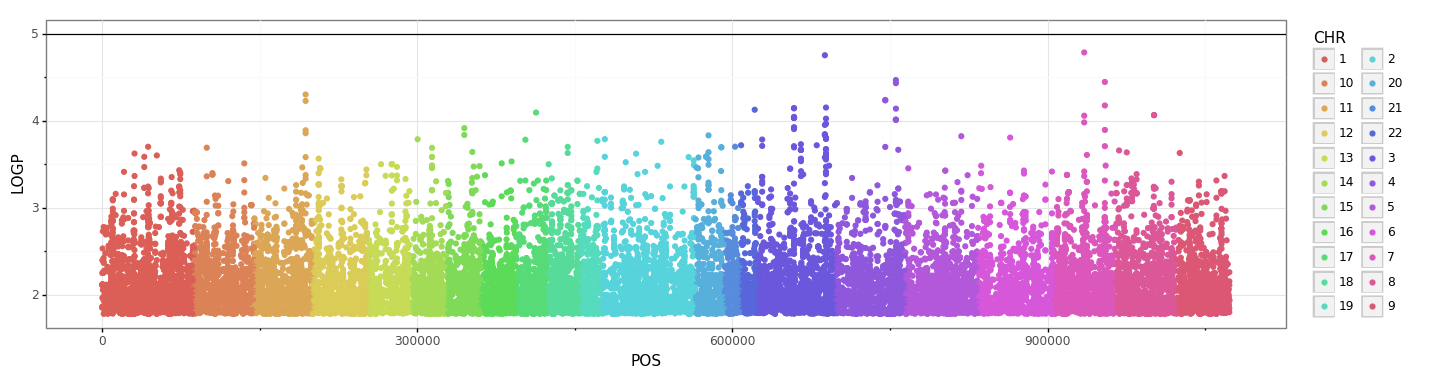

<ggplot: (8729997682305)>

In [80]:
manhattan_plot(df)

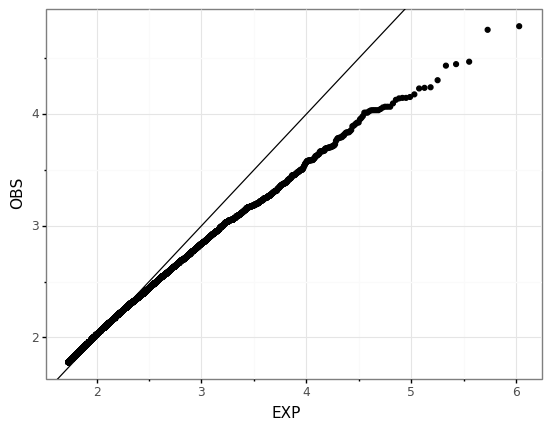

<ggplot: (8729894719793)>

In [82]:
qq_plot(df)